<a href="https://colab.research.google.com/github/20v100/Coursera_Capstone/blob/master/JOC_Coursera_Capstone_Copy5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. INTRODUCTION

According to the latest information published by the U.S. Census Bureau the percentage of people that move every year equates to 14% of the population (or roughly 40 million). People move for a variety of reasons: housing, jobs, family, etc. __[link](https://www.northamerican.com/migration-map)__

When evaluating which city to settle in, movers may like to compare the similarity of other cities to the city they are living in.


When exploring other cities that one could move to, the similarity of venues could be used to assess similarities amongst cities.


# 2. DATA OVERVIEW

This project leverage Foursquare API to compare venues in different cities. Venues in each studied cities are compared base on:

- Their categories (Coffe shops, steakhouses, etc.)
- The frequencies of venues in each category

For the purpose of this project, the following cities are compared:

- Calgary       
- Dallas        
- Denver        
- Houston        
- Miami         
- Montreal      
- New York      
- Toronto       
- Vancouver     
- Washington    

**Limitations**

Foursquare free membership limits the number of venues that can be fetched to 100 per city per call. Since the present project is for academic purpose, only 100 venues were extracted per city. Real life applications of the model should consider taking a paid membership. The sampled cities were within a radius of 2km around the center of the cities.

# 3. METHODOLOGY

<br>
During the first iterations of the below project, it was discovered the most frequent venue category was "Hotel". Since potential movers aren't looking to buy or rent a property, this category is now removed from the dataset.

Also, the categories "Coffee Shop" and "Café" are merged together since "Café" is the French equivalent of "Coffee Shop".

The cities are mapped in 3 clusters using K-Means. K-Means is a proven unsupervised ML technique to classify features with several dependent variables.

Visualization techniques used are geographical maps to clearly locate the clusters and Heatmap. Heatmaps are useful to interpret cluster patterns identified by the K-Means technique.

## Libraries, Packages and Credentials

In [0]:
# import the libraries

# Basic Libraries
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
from matplotlib import pyplot
import matplotlib.cm as cm
import matplotlib.colors as colors
print('All imported')
import seaborn as sns

# plotting library
!pip install folium
import folium

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')

All imported
twisted 18.7.0 requires PyHamcrest>=1.9.0, which is not installed.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Libraries imported.


In [0]:
#Four Square Credentials
CLIENT_ID = 'Z4G102XHUFAUSKXKLFW01UEVDEO3XIDLWNTGEWAKJDNN21JW' # your Foursquare ID
CLIENT_SECRET = 'TFQ4CBEKWNASZD4FROH4NHUS5PWSGRT2A14RWA3UFRFC54EU' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 500
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: Z4G102XHUFAUSKXKLFW01UEVDEO3XIDLWNTGEWAKJDNN21JW
CLIENT_SECRET:TFQ4CBEKWNASZD4FROH4NHUS5PWSGRT2A14RWA3UFRFC54EU


# 4. RESULTS
Results section where you discuss the results

## Data Loading

### Defining cities to analyse 

In [0]:
cities = {'name': ['Montreal', 'Toronto', 'Vancouver', 'Calgary', 'New York', 'Denver', 'Dallas', 'Miami', 'Houston', 'Washington', 'Los Angeles'],
         'lat': [45.5017, 43.6532, 49.2827, 51.0486, 40.7128, 39.7392, 32.7767, 25.7617, 29.7604, 38.9072, 34.0522], 
         'long': [-73.5673, -79.3832, -123.1207, -114.0708, -74.0060, -104.9903, -96.7970, -80.1918, -95.3698, -77.0369, -118.2437]
        }

city_df = pd.DataFrame(cities)
city_df.head()

,name,lat,long
0,Montreal,45.5017,-73.5673
1,Toronto,43.6532,-79.3832
2,Vancouver,49.2827,-123.1207
3,Calgary,51.0486,-114.0708
4,New York,40.7128,-74.0060


In [0]:
# create map

latitude  = 40
longitude = -105.2551
zoom_start = 4

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=zoom_start)

# # set color scheme for the clusters
# x = np.arange(city_df['name'])
# ys = [i+x+(i*x)**2 for i in range(city_df['name'])]
# colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
# rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_df['lat'], city_df['long'], city_df['name'], city_df['name']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
#         color=rainbow[cluster-1],
        fill=True,
#         fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Loading Foursquare information on the selected cities

In [0]:
# Function that explore cities
# Radius is 2 KM
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['city', 
                  'city Latitude', 
                  'city Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [0]:
# Resquest info on venues from Foursquare
city_venues = getNearbyVenues(names=city_df['name'],
                                   latitudes=city_df['lat'],
                                   longitudes=city_df['long']
                                  )

Montreal
Toronto
Vancouver
Calgary
New York
Denver
Dallas
Miami
Houston
Washington
Los Angeles


In [0]:
city_venues.head()

,city,city Latitude,city Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Montreal,45.5017,-73.5673,The Keg Steakhouse & Bar,45.500730,-73.568971,Steakhouse
1,Montreal,45.5017,-73.5673,"96,9 CKOI",45.500000,-73.565269,Music Venue
2,Montreal,45.5017,-73.5673,Escondite,45.503045,-73.567888,Taco Place
3,Montreal,45.5017,-73.5673,Tunnel Espresso,45.502167,-73.569954,Coffee Shop
4,Montreal,45.5017,-73.5673,Il Focolaio,45.504009,-73.568213,Pizza Place


In [0]:
city_venues.shape

(1100, 7)

In [0]:
# Let's find out how many unique categories can be curated from all the returned venues
print('There are {} uniques categories.'.format(len(city_venues['Venue Category'].unique())))

There are 204 uniques categories.


In [0]:
city_venues.groupby(['city']).size()

city
Calgary        100
Dallas         100
Denver         100
Houston        100
Los Angeles    100
Miami          100
Montreal       100
New York       100
Toronto        100
Vancouver      100
Washington     100
dtype: int64

## Data Wrangling

In [0]:
# Map Vanue Category "Cafe" to the english equivalent
city_venues.replace('Café', 'Coffee Shop', inplace=True)
# city_venues.head()

## Onehot encoding

In [0]:
# one hot encoding
venues_onehot = pd.get_dummies(city_venues[['Venue Category']], prefix="", prefix_sep="")

# venues_onehot.to_csv('venues_onehot.csv')
# venues_onehot.head()
venues_onehot.shape


(1100, 203)

In [0]:
# Hotel is one of the most frequent category and is excluded since the 
# stakeholder is not interrested staying at the hotel but move in the location

venues_onehot.drop('Hotel',1, inplace=True)
# venues_onehot.shape

In [0]:
venues_onehot.columns

Index(['American Restaurant', 'Antique Shop', 'Aquarium', 'Arcade',
       'Argentinian Restaurant', 'Art Gallery', 'Art Museum',
       'Arts & Crafts Store', 'Asian Restaurant', 'Athletics & Sports',
       ...
       'Turkish Restaurant', 'Vegetarian / Vegan Restaurant',
       'Vietnamese Restaurant', 'Whisky Bar', 'Wine Bar', 'Wine Shop',
       'Wings Joint', 'Women's Store', 'Yoga Studio', 'Yoshoku Restaurant'],
      dtype='object', length=202)

In [0]:
venues_onehot.shape

(1100, 202)

In [0]:
# Merging the onehot with the city information
city_onehot = city_venues.join(venues_onehot)
city_onehot.drop(['city Latitude', 'city Longitude','Venue Latitude', 'Venue Longitude'] ,1, inplace=True)
# city_onehot.to_csv('city _onehot.csv')
city_onehot.shape

(1100, 205)

In [0]:
city_onehot.head()

,city,Venue,Venue Category,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant
0,Montreal,The Keg Steakhouse & Bar,Steakhouse,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Montreal,"96,9 CKOI",Music Venue,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Montreal,Escondite,Taco Place,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Montreal,Tunnel Espresso,Coffee Shop,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Montreal,Il Focolaio,Pizza Place,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# Next, let's group rows by cities and by taking the mean of the frequency of occurrence of each category
city_grouped = city_onehot.groupby(['city']).mean()
city_grouped.reset_index(inplace=True)
city_grouped.head(10)

,city,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant
0,Calgary,0.03,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.01,0.02,0.00,0.01,0.00,0.00,0.00,0.02,0.00
1,Dallas,0.04,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
2,Denver,0.03,0.00,0.00,0.0,0.00,0.01,0.02,0.00,0.00,...,0.0,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00
3,Houston,0.00,0.00,0.01,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.01,0.02,0.00,0.00,0.00,0.00,0.00
4,Los Angeles,0.01,0.00,0.00,0.0,0.00,0.02,0.02,0.01,0.00,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01
5,Miami,0.02,0.00,0.00,0.0,0.03,0.00,0.00,0.00,0.01,...,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
6,Montreal,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.01,0.00,...,0.0,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00
7,New York,0.02,0.01,0.00,0.0,0.00,0.00,0.00,0.00,0.01,...,0.0,0.01,0.00,0.00,0.00,0.01,0.00,0.01,0.02,0.00
8,Toronto,0.05,0.00,0.00,0.0,0.00,0.00,0.01,0.01,0.02,...,0.0,0.01,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00
9,Vancouver,0.02,0.00,0.00,0.0,0.00,0.01,0.00,0.00,0.00,...,0.0,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.01,0.00


In [0]:
city_grouped.shape

(11, 203)

In [0]:
city_grouped.to_csv('city_grouped.csv')

## K-Means Analysis

### Model fitting

In [0]:
# set number of clusters
kclusters = 3

city_grouped_clustering = city_grouped.drop(['city'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(city_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 1, 0, 2, 0, 1, 0, 2], dtype=int32)

In [0]:
# Merge back the labels

city_clusters = city_grouped

# add clustering labels
city_clusters['Cluster Labels'] = kmeans.labels_

# add lat long
city_clusters = pd.merge(city_df, city_clusters, left_on='name', right_on='city')
city_clusters.drop('name', 1, inplace=True)

city_clusters.head()

,lat,long,city,American Restaurant,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,...,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Yoshoku Restaurant,Cluster Labels
0,45.5017,-73.5673,Montreal,0.00,0.00,0.0,0.0,0.0,0.00,0.00,...,0.01,0.00,0.0,0.00,0.00,0.0,0.00,0.01,0.0,0
1,43.6532,-79.3832,Toronto,0.05,0.00,0.0,0.0,0.0,0.00,0.01,...,0.01,0.00,0.0,0.00,0.00,0.0,0.01,0.00,0.0,0
2,49.2827,-123.1207,Vancouver,0.02,0.00,0.0,0.0,0.0,0.01,0.00,...,0.00,0.00,0.0,0.01,0.00,0.0,0.00,0.01,0.0,2
3,51.0486,-114.0708,Calgary,0.03,0.00,0.0,0.0,0.0,0.00,0.00,...,0.01,0.02,0.0,0.01,0.00,0.0,0.00,0.02,0.0,0
4,40.7128,-74.0060,New York,0.02,0.01,0.0,0.0,0.0,0.00,0.00,...,0.01,0.00,0.0,0.00,0.01,0.0,0.01,0.02,0.0,1


### Understanding the clusters composition 

In [0]:
# Visualaizing Cluster Groups
[print(row['Cluster Labels'], row['city']) 
                 for idx, row in city_clusters.sort_values('Cluster Labels').iterrows()]

0 Montreal
0 Toronto
0 Calgary
0 Dallas
0 Los Angeles
1 New York
1 Denver
1 Houston
1 Washington
2 Vancouver
2 Miami


[None, None, None, None, None, None, None, None, None, None, None]

In [0]:
# Visualaizing Cluster Groups
city_clusters_t = city_clusters.sort_values('Cluster Labels', ascending=False)
city_clusters_t2 = city_clusters_t.loc[:,'city':'Cluster Labels']
city_clusters_t2  = city_clusters_t2.transpose()
city_clusters_t2.columns = city_clusters_t2.loc['city']
city_clusters_t2.drop('city', inplace=True)
city_clusters_t2.tail()

city,Vancouver,Miami,New York,Denver,Houston,Washington,Montreal,Toronto,Calgary,Dallas,Los Angeles
Wings Joint,0,0,0,0,0,0,0,0,0,0.01,0
Women's Store,0,0,0.01,0,0,0,0,0.01,0,0,0
Yoga Studio,0.01,0.01,0.02,0.03,0,0.03,0.01,0,0.02,0,0
Yoshoku Restaurant,0,0,0,0,0,0,0,0,0,0,0.01
Cluster Labels,2,2,1,1,1,1,0,0,0,0,0


In [0]:
city_clusters_t2.head()

city,Vancouver,Miami,New York,Denver,Houston,Washington,Montreal,Toronto,Calgary,Dallas,Los Angeles
American Restaurant,0.02,0.02,0.02,0.03,0,0.05,0,0.05,0.03,0.04,0.01
Antique Shop,0,0,0.01,0,0,0,0,0,0,0,0
Aquarium,0,0,0,0,0.01,0,0,0,0,0,0
Arcade,0,0,0,0,0,0.01,0,0,0,0,0
Argentinian Restaurant,0,0.03,0,0,0,0,0,0,0,0,0


### Mapping the clusters

In [0]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_clusters['lat'], city_clusters['long'], city_clusters['city'], city_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

###  Clusters Heatmap

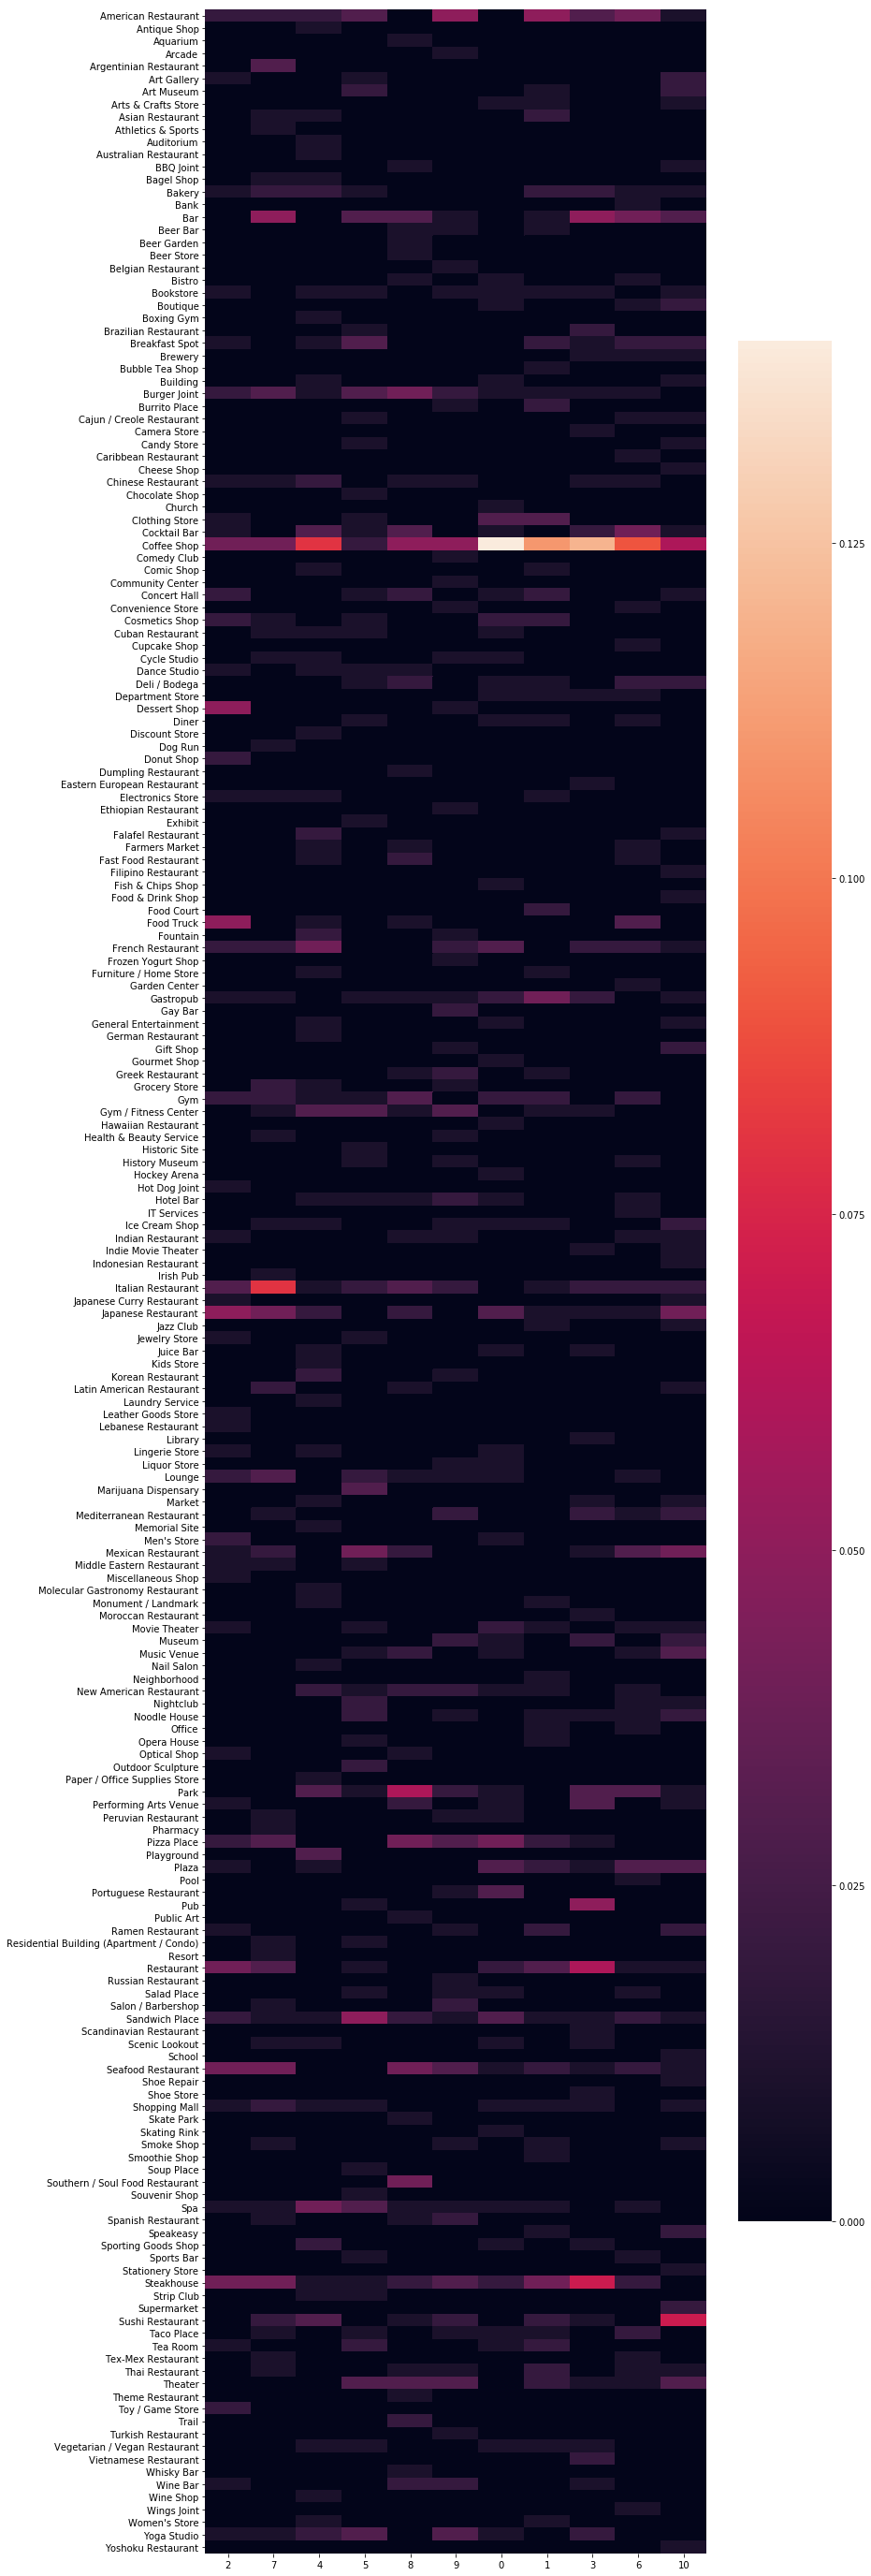

In [0]:
# Mapping the clusters
city_clusters_t = city_clusters.sort_values('Cluster Labels', ascending=False)
city_clusters_t2 = city_clusters_t.loc[:,'American Restaurant':'Yoshoku Restaurant']
city_clusters_t2  = city_clusters_t2.transpose()

dims = (12, 50)
fig, ax = pyplot.subplots(figsize=dims)
sns.heatmap(ax=ax, data=city_clusters_t2)
# plt.show()

# 5. DISCUSSION

The **Cluster 0** (Vancouver, BC and Miami) is formed of 2 coastal cities. It could be named the "Coastal Cluster". In this cluster, the venues of the type sushi and other Asian type cuisine are prevalent.

The **Cluster 1** is composed of:

- Montreal,
- Toronto,
- Dallas,
- Los Angeles,
- and Calgary 
<br>
In this cluster, coffee shops, American style restaurants, and teakhouses are prevalent. This cluster could be called the "Coffee Shop Lifestyle"

The **Cluster 2** is composed of:
- New York
- Denver
- Houston
- Washington
<br>
In this cluster, we see a prevalence of the venues types "Park", "Yoga Studio", "Theatre", "Spa", "Gym/Fitness Centers", ect. Hence, the cluster is called the "Health Cluster".


# 6. CONCLUSION
This project highlighted a clear independent pattern in the type of venues across the studied cities. 
<br>

However, several biases could be in play in the dataset. One could suppose that Foursquare users tend to follow users that are located in same cities. Opinion leaders in each city could favor a certain type of venues over others. These type of venues will then be over-represented when comparing to the real physical occurrences in the city in question.

For example, in the "Health Cluster", is possible that "Health conscious" communities started to use Foursquare to evaluate spa, gym, etc. While other services - like Yelp - are more in vogue to rank these type of venues in other cities.

Nevertheless, this project shows that service like Foursquare can be used to compare cities.